In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from diffusion_equation import compute_solution
from time import time

# Getting data from simulator

In [4]:
# configuration of simulator
# and parametrs of reservouir
pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3


pmin = 0.0
pmax = 1.0
nx0 = 50
nx1 = 30
nx2 = 1
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

niter = 5000
t_final = 3.0
dt = t_final / niter

poro = 0.1 + np.zeros((nx0, nx1, nx2))
perm = np.ones((nx0, nx1, nx2))

pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, t_final, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

x_list = np.random.randint(size=niter, low=0, high=50)
y_list = np.random.randint(size=niter, low=0, high=30)
dt_n = np.random.randint(size=niter, low=0, high=niter)

# 0 - pres, 1 - swat, 2 - soil
sim_data = np.zeros((niter, 3))

# simulation
for i in range(niter):
    sim_data[i, 0] = pres[x_list[i], y_list[i], 0, dt_n[i]]
    sim_data[i, 1] = swat[x_list[i], y_list[i], 0, dt_n[i]]
    sim_data[i, 2] = soil[x_list[i], y_list[i], 0, dt_n[i]]

#   saving data in file
N = niter
np.savetxt(f"data_5k/sim_{N}.txt", sim_data)
np.savetxt(f"data_5k/x_{N}.txt", x_list)
np.savetxt(f"data_5k/y_{N}.txt", y_list)
np.savetxt(f"data_5k/t_{N}.txt", dt_n)

In [2]:
swat.shape

NameError: name 'swat' is not defined

# Read from file

In [2]:
# sim_data: pres, swat, soil

# # 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

# # 5000
# sim_data = np.loadtxt("5000_data/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("5000_data/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("5000_data/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("5000_data/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

# 5000
sim_data = np.loadtxt("data_5k/sim_5000.txt", dtype=np.float32)
x_list = np.loadtxt("data_5k/x_5000.txt", dtype=np.float32)
y_list = np.loadtxt("data_5k/y_5000.txt", dtype=np.float32)
t_list = np.loadtxt("data_5k/t_5000.txt", dtype=np.float32)
sim_data, x_list, y_list, t_list

(array([[ 6.7007446e-01,  3.4688506e-01,  6.5311497e-01],
        [ 5.5435652e-01, -5.7010649e-35,  1.0000000e+00],
        [ 4.7860157e-01,  2.8430817e-01,  7.1569186e-01],
        ...,
        [ 2.6230749e-01,  4.6085242e-34,  1.0000000e+00],
        [ 2.6679090e-01, -3.7726316e-34,  1.0000000e+00],
        [ 2.7647346e-01, -4.8818143e-35,  1.0000000e+00]], dtype=float32),
 array([ 9., 21., 18., ..., 34., 34., 35.], dtype=float32),
 array([ 6., 20.,  3., ...,  0.,  6., 14.], dtype=float32),
 array([4161.,  818., 4701., ..., 2969., 2690., 1120.], dtype=float32))

# Convert to torch tensor

In [3]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list).requires_grad_(True)

pwat1 = 2.0 * torch.ones_like(x).requires_grad_(True)
poil1 = 4.0 * torch.ones_like(x).requires_grad_(True)
kwat1 = 1.0 * torch.ones_like(x).requires_grad_(True)
koil1 = 0.3 * torch.ones_like(x).requires_grad_(True)

points = torch.stack((t, x, y, pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
points, simulation_data

NameError: name 'dx0' is not defined

# Boundary points

In [12]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y, pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
pres1_x1_points = torch.stack((t, torch.ones_like(x), y, pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y, pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y, pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
u0_x2_points = torch.stack((t, x, torch.zeros_like(y), pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)
u1_x2_points = torch.stack((t, x, torch.ones_like(y), pwat1, kwat1, poil1, koil1), -1).requires_grad_(True)

# Model configuration

In [13]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 7, hidden_layer = 32, number_layers = 4, output_layer = 9):
        super().__init__()
        
        activation2 = nn.Sigmoid
        activation1 = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation1()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        function for updating neural network
        
        return:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y,
                        kwat,
                        koil)
        """
        
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

# Model training

In [37]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss0_hist = []
loss1_hist = []
loss2_hist = []

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.param_groups[0]['lr'] = 0.001

In [41]:
# neural network returns:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y) 


# points - (t, x, y, pwat1, kwat1, poil1, koil1)
epochs = 10000
optimizer.param_groups[0]['lr'] = 0.005

for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    model_res = model(points).requires_grad_(True)
    # presseru bound
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
    # struation boundary
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # velocity boundary
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    one_vector = torch.ones_like(model_res[:, 0])
    zeros_vector = torch.zeros_like(model_res[:, 0])
    
    # functions r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    
    
    r3_x1 = model_res[:, 5] + (model_res[:, 2] ** points[0, 3]) * (torch.autograd.grad(model_res[:, 0], 
                                                                        x, one_vector, 
                                                                        create_graph=True)[0])
    
    r3_x2 = model_res[:, 6] + (model_res[:, 2] ** points[0, 3]) * (torch.autograd.grad(model_res[:, 0], 
                                                                        y, one_vector, 
                                                                        create_graph=True)[0])
    
    r4_x1 = model_res[:, 3] + (1/3) *  points[0, 6] * (model_res[:, 1] ** points[0, 5]) * (torch.autograd.grad(model_res[:, 0], 
                                                                                     x, one_vector, 
                                                                                     create_graph=True)[0])
    
    r4_x2 = model_res[:, 4] + (1/3) *  points[0, 6] * (model_res[:, 1] ** points[0, 5]) * (torch.autograd.grad(model_res[:, 0], 
                                                                                     y, one_vector, 
                                                                                     create_graph=True)[0])
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
                       r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil0 - one_vector)**2 + swat0**2 +\
                       uwat0_x2**2 + uwat1_x2**2 +\
                       uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)
    
    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,2] - simulation_data[:,1])**2 + \
                       (model_res[:,1] - simulation_data[:,2])**2).requires_grad_(True)
    

    l1 = loss1.clone().detach().requires_grad_(True)
    l2 = loss2.clone().detach().requires_grad_(True)
    l0 = loss0.clone().detach().requires_grad_(True)
    l1.backward(retain_graph=True)
    l2.backward(retain_graph=True)
    l0.backward(retain_graph=True)
    w0 = abs(l0 / (l0 + l1 + l2))
    w1 = abs(l1 / (l1 + l0 + l2))
    w2 = abs(l2 / (l1 + l0 + l2))
    
    loss0_hist.append(loss0.detach().numpy())
    loss1_hist.append(loss1.detach().numpy())
    loss2_hist.append(loss2.detach().numpy())
    # итоговый функционал потерь
    # loss = loss0 + loss1 + loss2
    dist = loss0 + loss1 + loss2
    loss = 0.3 * loss0 + 0.4 * loss1 + 0.3 * loss2
    loss.backward(retain_graph=True)
    optimizer.step()
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')
        print(w0, '\t', w1, '\t', w2)

  0%|                                                                                                                 | 5/10000 [00:00<08:01, 20.76it/s]

epoch: 0	loss: (0.007727357558906078, 0.002933297073468566, 0.0003557584423106164, 0.004438302014023066)	
tensor(0.3796, grad_fn=<AbsBackward0>) 	 tensor(0.0460, grad_fn=<AbsBackward0>) 	 tensor(0.5744, grad_fn=<AbsBackward0>)


  3%|██▊                                                                                                            | 254/10000 [00:10<06:17, 25.81it/s]

epoch: 250	loss: (0.6197425723075867, 0.0010345976334065199, 0.500174880027771, 0.11853305995464325)	
tensor(0.0017, grad_fn=<AbsBackward0>) 	 tensor(0.8071, grad_fn=<AbsBackward0>) 	 tensor(0.1913, grad_fn=<AbsBackward0>)


  5%|█████▌                                                                                                         | 506/10000 [00:19<06:05, 25.97it/s]

epoch: 500	loss: (0.6158947348594666, 0.00023155365488491952, 0.4981115162372589, 0.11755166947841644)	
tensor(0.0004, grad_fn=<AbsBackward0>) 	 tensor(0.8088, grad_fn=<AbsBackward0>) 	 tensor(0.1909, grad_fn=<AbsBackward0>)


  8%|████████▍                                                                                                      | 755/10000 [00:29<05:53, 26.14it/s]

epoch: 750	loss: (0.5779433250427246, 0.0004107389540877193, 0.4620899558067322, 0.11544264107942581)	
tensor(0.0007, grad_fn=<AbsBackward0>) 	 tensor(0.7995, grad_fn=<AbsBackward0>) 	 tensor(0.1997, grad_fn=<AbsBackward0>)


  9%|██████████▎                                                                                                    | 925/10000 [00:36<05:56, 25.48it/s]


KeyboardInterrupt: 

In [17]:
def main2000(model):
    print('inside the main function')

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    # pwat = 1.0
    # poil = 1.0
    # vr = 1.0
    # kwat = 1.0
    # koil = 1.0
    pmin = 0.0
    pmax = 1.0
    nx0 = 50
    nx1 = 30
    nx2 = 1
    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    dt = 0.26e-1
    niter = 100

    poro = 0.1 + np.zeros((nx0, nx1, nx2))
    perm = np.ones((nx0, nx1, nx2))
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
#     print(swat.shape)
#     print(swat)
    time_for_model = (niter * dt) * torch.ones(1500)
    x_for_model = dx0 * torch.arange(50)
    y_for_model = dx1 * torch.arange(30)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()

#     plt.figure()
#     plt.imshow(pres)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.show()
    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды, симулятор')
#     plt.imshow(swat)
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Насыщенность воды, модель')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
    
    plt.figure()
    plt.title('Давление, симулятор')
    plt.imshow(pres)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Давление, модель')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_pinn.png')
    plt.show()
    
#     plt.figure()
#     plt.imshow(soil)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
#     plt.show()


#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Давление')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



    return 0

inside the main function


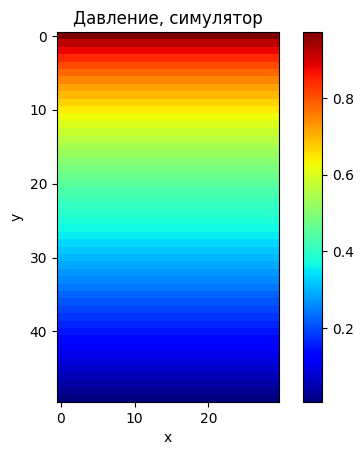

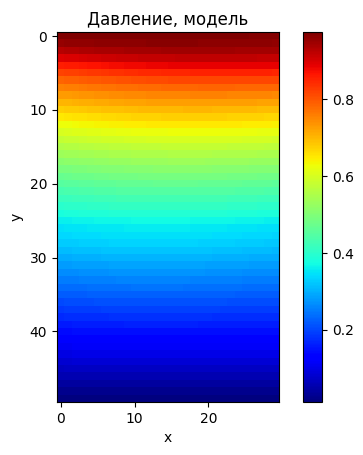

0

In [18]:
main2000(model)

In [19]:
def main5k(model):
    print('inside the main function')

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    # pwat = 1.0
    # poil = 1.0
    # vr = 1.0
    # kwat = 1.0
    # koil = 1.0
    pmin = 0.0
    pmax = 1.0
    nx0 = 50
    nx1 = 30
    nx2 = 1
    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    dt = 0.7e-1
    niter = 100

    poro = 0.1 + np.zeros((nx0, nx1, nx2))
    perm = np.ones((nx0, nx1, nx2))
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
#     print(swat.shape)
#     print(swat)
    time_for_model = (niter * dt) * torch.ones(1500)
    x_for_model = dx0 * torch.arange(50)
    y_for_model = dx1 * torch.arange(30)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()

#     plt.figure()
#     plt.imshow(pres)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.show()
    
    
    
    plt.figure()
    plt.imshow(swat)
    plt.show()
    
    plt.figure()
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.show()
    
#     plt.figure()
#     plt.imshow(soil)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
#     plt.show()


    plt.figure()
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0], label='sim')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='pinn')
    plt.grid()
    plt.show()

    plt.figure()
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0], label='sim')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='pinn')
    plt.grid()
    plt.show()



    return 0

inside the main function


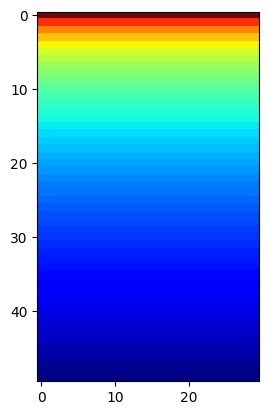

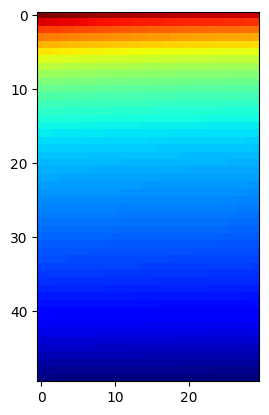

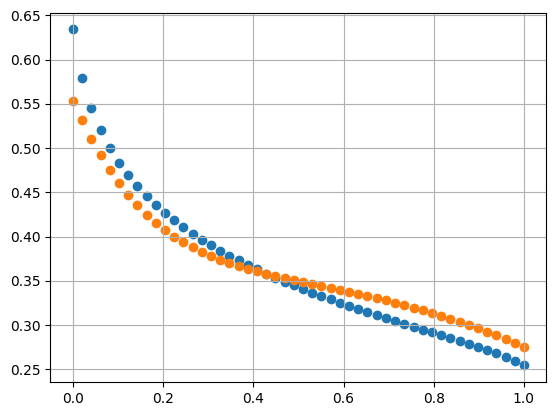

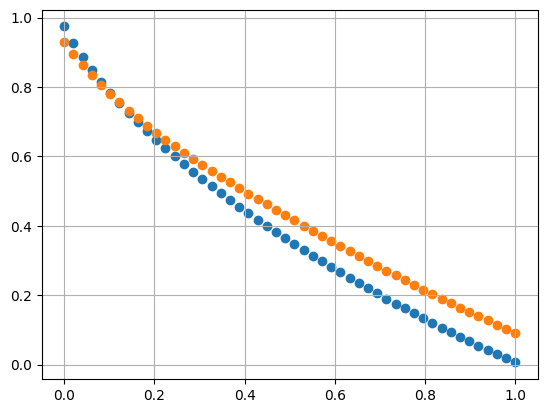

0

In [20]:
main5k(model)

In [ ]:
# loss0_hist
# loss1_hist
# loss2_hist
plt.figure()
plt.plot(np.arange(10000), torch.tensor(w0_hist).detach().numpy()[:10000], label='w0')
plt.plot(np.arange(10000), torch.tensor(w1_hist).detach().numpy()[:10000], label='w1')
plt.plot(np.arange(10000), torch.tensor(w2_hist).detach().numpy()[:10000], label='w2')
plt.grid()
plt.xlabel('Итерация')
plt.ylabel('Значение веса')
plt.legend()
# plt.savefig('2Dweights.png')
plt.show()


plt.figure()
plt.plot(np.arange(10000), loss0_hist[:10000], label='loss0')
plt.plot(np.arange(10000), loss1_hist[:10000], label='loss1')
plt.plot(np.arange(10000), loss2_hist[:10000], label='loss2')
plt.grid()
plt.ylim(0, 0.1)
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.legend()
# plt.savefig('2Dloss.png')
plt.show()

In [63]:
torch.tensor(w0_hist)

tensor([0.3126, 0.3055, 0.2979,  ..., 0.2024, 0.2019, 0.2027])